<a href="https://colab.research.google.com/github/ArtyomShabunin/PINNModels/blob/main/experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlflow==2.22.1 dagshub --quiet
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [208]:
import mlflow
import dagshub
import pandas as pd
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt

In [4]:
dagshub.init("gas-prop-net", "pranamodeling", mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=8a578880-4f48-47f8-9538-92b4169ae056&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=cfede1f2332d414604558f375bd8913378a121533a504616e1b83fe8df485021




Accessing as pranamodeling

Initialized MLflow to track repo "pranamodeling/gas-prop-net"

Repository pranamodeling/gas-prop-net initialized!

### Модель для расчета свойств смесей газов

In [5]:
class GasMixturePropertiesNN(nn.Module):
    def __init__(self, logged_model_uri: str, logged_info_uri: str, freeze: bool = True):
        super().__init__()
        # Загрузка модели и информации о нормализации
        self.raw_model = mlflow.pyfunc.load_model(logged_model_uri).get_raw_model()

        # Заморозка весов
        if freeze:
            for param in self.raw_model.parameters():
                param.requires_grad = False

        with open(mlflow.artifacts.download_artifacts(logged_info_uri)) as f:
            self.model_info = json.load(f)

        # Преобразуем mean и std в тензоры
        self.register_buffer('input_mean', torch.tensor(self.model_info['scaler_input']['mean_'], dtype=torch.float32))
        self.register_buffer('input_std', torch.tensor(self.model_info['scaler_input']['std_'], dtype=torch.float32))
        self.register_buffer('output_mean', torch.tensor(self.model_info['scaler_output']['mean_'], dtype=torch.float32))
        self.register_buffer('output_std', torch.tensor(self.model_info['scaler_output']['std_'], dtype=torch.float32))

    def forward(self, x1: torch.Tensor, x2: torch.Tensor, x3: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
            inputs: Tensor размера (batch_size, n_features) — давление, температура/энтальпия, состав смеси и т.д.
        Returns:
            Tensor размера (batch_size, n_outputs) — физические свойства: T/h, rho, s, mu, lambda, cp
        """

        inputs = torch.cat([x1, x2, x3], axis=1)

        # Нормализация
        x_norm = (inputs - self.input_mean) / self.input_std

        # Предсказание
        y_norm = self.raw_model(x_norm)

        # Обратная нормализация
        y = y_norm * self.output_std + self.output_mean

        return {key:y[:,i:i+1] for i, key in enumerate(self.model_info['output'])}

In [6]:
# Инициализация моделей
gas_pHX = GasMixturePropertiesNN(
    logged_model_uri='runs:/7febe97b33db4e978445b2290c9453d1/mdllol',
    logged_info_uri='mlflow-artifacts:/e7cc815685774faa9f6b047a083f2220/7febe97b33db4e978445b2290c9453d1/artifacts/info.json'
)

gas_pTX = GasMixturePropertiesNN(
    logged_model_uri='runs:/71d154b2c086407d960720ca8fd2012f/mdllol',
    logged_info_uri='mlflow-artifacts:/814e64636dca42cfbac0984ece9bc5fd/71d154b2c086407d960720ca8fd2012f/artifacts/info.json'
)

gas_pSX = GasMixturePropertiesNN(
    logged_model_uri='runs:/dfc4889750c54fd4a388c93fb57819ee/mdllol',
    logged_info_uri='mlflow-artifacts:/25c2c06c1c7f43d3bb10a131022afe84/dfc4889750c54fd4a388c93fb57819ee/artifacts/info.json'
)

2025/06/24 06:55:02 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - boto3 (current: 1.38.42, required: boto3==1.38.41)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


2025/06/24 06:55:18 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - boto3 (current: 1.38.42, required: boto3==1.38.40)
 - pytorch-lightning (current: 2.5.2, required: pytorch-lightning==2.5.1.post0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


2025/06/24 06:55:30 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - boto3 (current: 1.38.42, required: boto3==1.38.41)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [7]:
# Тестовый пример
p = torch.tensor([[1e5]])  # Па
T = torch.tensor([[500+273.15]])  # C
X = torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]])  # молярные доли

# Вызов модели
output_1 = gas_pTX(p, T, X)

output_1

{'h': tensor([[-103818.]]),
 'rho': tensor([[0.3462]]),
 's': tensor([[7495.7749]]),
 'mu': tensor([[3.5630e-05]]),
 'lamb': tensor([[0.0549]]),
 'cp': tensor([[1094.5057]])}

In [8]:
# Вызов модели
output_2 = gas_pHX(p, output_1['h'], X)

print(output_2['T']-273.15)

# output_2

tensor([[517.7427]])


In [9]:
# Вызов модели
output_3 = gas_pSX(p, output_1['s'], X)

output_3['T']-273.15

tensor([[409.2821]])

In [10]:
output_1['rho'], output_2['rho'], output_3['rho']

(tensor([[0.3462]]), tensor([[0.1494]]), tensor([[0.6985]]))

In [11]:
output_1['cp'], output_2['cp'], output_3['cp']

(tensor([[1094.5057]]), tensor([[1094.6322]]), tensor([[1085.6976]]))

In [13]:
# Расчет производных

# Сделаем h дифференцируемым
p = torch.tensor([[1e5]], dtype=torch.float32, requires_grad=True)
h = torch.tensor([[-99757.]], dtype=torch.float32, requires_grad=True)
X = torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]], dtype=torch.float32)  # X можно оставить без градиента

# Вызов surrogate-модели
out = gas_pHX(p, h, X)  # dict с ключом 'rho'
rho = out['rho']  # (batch, 1)

# Вычисляем drho/dh
drho_dh = torch.autograd.grad(
    outputs=rho,
    inputs=h,
    grad_outputs=torch.ones_like(rho),
    create_graph=True
)[0]  # (batch, 1)

## Граничные условия

In [14]:
class PressureTemperatureBC(nn.Module):
    def __init__(self, gas_pTX: GasMixturePropertiesNN):
        super().__init__()
        self.gas_pTX = gas_pTX

    def forward(self, p: torch.Tensor, T: torch.Tensor, X: torch.Tensor) -> torch.Tensor:

        return {
            'p': p,
            'h': self.gas_pTX(p,T, X)['h'],
            'X': X
        }


## Модель компрессора

### CompressorMapInterp — таблично заданная карта по β и скорости вращения

In [15]:
class CompressorMapInterp(nn.Module):
    def __init__(self, betas, speeds, table_phi, table_pi_c, table_eta):
        super().__init__()

        # Сетка значений beta и speed_rel
        self.register_buffer('betas', torch.tensor(betas, dtype=torch.float32))  # β
        self.register_buffer('speeds', torch.tensor(speeds, dtype=torch.float32))  # относит. скорости

        # Таблицы: (n_beta, n_speed)
        self.register_buffer('table_phi', torch.tensor(table_phi))

        self.register_buffer('table_pi_c', torch.tensor(table_pi_c))

        self.register_buffer('table_eta', torch.tensor(table_eta))

    def forward(self, beta, speed_rel):
        """
        :param beta: (batch,) значение бета — непрерывное
        :param speed_rel: (batch,) относительная приведенная скорость вращения
        :return: pi_c, phi, eta — (batch,)
        """

        # Индексы по β
        beta_low_idx = torch.clamp(torch.searchsorted(self.betas, beta, right=False) - 1, 0, len(self.betas) - 2)
        beta_high_idx = beta_low_idx + 1

        beta0 = self.betas[beta_low_idx]
        beta1 = self.betas[beta_high_idx]
        w_beta = (beta - beta0) / (beta1 - beta0 + 1e-6)

        # Индексы по скорости
        speed_low_idx = torch.clamp(torch.searchsorted(self.speeds, speed_rel, right=False) - 1, 0, len(self.speeds) - 2)
        speed_high_idx = speed_low_idx + 1

        speed0 = self.speeds[speed_low_idx]
        speed1 = self.speeds[speed_high_idx]
        w_speed = (speed_rel - speed0) / (speed1 - speed0 + 1e-6)

        def bilinear_interp(table):
            # Получаем значения по индексам
            val00 = table[beta_low_idx, speed_low_idx]
            val01 = table[beta_low_idx, speed_high_idx]
            val10 = table[beta_high_idx, speed_low_idx]
            val11 = table[beta_high_idx, speed_high_idx]

            # Интерполяция по скорости
            val0 = val00 + w_speed * (val01 - val00)
            val1 = val10 + w_speed * (val11 - val10)

            # Интерполяция по β
            return val0 + w_beta * (val1 - val0)

        phi = bilinear_interp(self.table_phi)
        pi_c = bilinear_interp(self.table_pi_c)
        eta = bilinear_interp(self.table_eta)

        return pi_c, phi, eta

### CompressorMapNetBeta — обучаемая карта по β и скорости вращения

In [269]:
class CompressorMapNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 3)  # pi_c, m_dot_rel, eta
        )

    def forward(self, beta, speed_rel):
        x = torch.stack([beta, speed_rel], dim=-1)
        out = self.net(x)
        pi_c = out[..., 0].clamp(min=1.01, max=10.0)
        m_dot_rel = out[..., 1].clamp(min=1e-4)
        eta = out[..., 2].clamp(min=0.1, max=1.0)
        return pi_c, m_dot_rel, eta

### Класс `Compressor`

In [320]:
class Compressor_2(nn.Module):
    def __init__(self, gas_pHX, gas_pSX, map, N_T_design = 3000, pi_design = 10):
        super().__init__()
        self.map = map
        self.N_T_design = N_T_design # приведенная скорость вращения, об/мин
        self.pi_design = pi_design

        self.gas_pHX = gas_pHX
        self.gas_pSX = gas_pSX

        self.keys = [
            'w', 'h_out', 'torque', 'pi_c', 'eta', 'phic']

    def forward(self, p_in, h_in, X_in, p_out, omega):

        # Термодинамические параметры газа перед компрессором
        state_in = self.gas_pHX(p_in, h_in, X_in)
        T_in = state_in['T']

        # Относительная приведенная скорость вращения
        N_T = omega/torch.sqrt(T_in/290)/self.N_T_design

        # Целевая степень повышения давления
        # pi_c = (p_out / p_in).clamp(min=1.01)
        pi_c = p_out / p_in
        pi_c_n = pi_c / self.pi_design

        # Использование характеристики компрессора
        phic, eta = self.map(pi_c_n, N_T)

        # Учет КПД
        s_in = state_in['s']
        state_iso = gas_pSX(p_out, s_in, X_in)
        h_out_iso = state_iso['h']
        delta_h_iso = h_out_iso - h_in
        delta_h = delta_h_iso / eta
        h_out = h_in + delta_h

        # Расход воздуха
        w = phic*p_in/1.013e5/torch.sqrt(T_in/290)

        torque = (w * delta_h) / (omega * 2 * torch.pi / 60 + 1e-6)

        return {k: v for k, v in zip(self.keys, [w, h_out, torque, pi_c, eta, phic])}

## Модель узла

In [246]:
class VolumeNode(nn.Module):
    def __init__(self, gas_pHX, volume=1, dt=0.01, h_ref=-656965.6250):
        super().__init__()
        self.volume = volume  # м³ — объём узла
        self.dt = dt  # временной шаг

        self.gas_pHX = gas_pHX

        self.h_ref = h_ref

    def forward(self, m_in, h_in, m_out, p_curr, h_curr, X_curr):
        """
        m_in: подача воздуха в узел (кг/с)
        h_in: энтальпия входящего воздуха (Дж/кг)
        m_out: расход из узла (кг/с)

        Возвращает: давление и температура в узле на текущем шаге
        """

        # Расчет плотности и производных плотности по энтальпии и давлению

        # Подготовка переменных с requires_grad
        p_curr_ = p_curr.detach().clone().requires_grad_(True)
        h_curr_ = h_curr.detach().clone().requires_grad_(True)

        state_carr = self.gas_pHX(p_curr_, h_curr_, X_curr)
        rho = state_carr['rho']

        # Вычисляем drho/dh
        drho_dh = torch.autograd.grad(
            outputs=rho,
            inputs=h_curr_,
            grad_outputs=torch.ones_like(rho),
            create_graph=True
        )[0]  # (batch, 1)

        # Вычисляем drho/dh
        drho_dp = torch.autograd.grad(
            outputs=rho,
            inputs=p_curr_,
            grad_outputs=torch.ones_like(rho),
            create_graph=True
        )[0]  # (batch, 1)

        # Перевод в относительные значения энтальпии
        h_in_rel = h_in - self.h_ref
        h_curr_rel = h_curr_ - self.h_ref

        # Текущая масса в узле
        m_curr = rho * self.volume

        # Текущая энергия в узле
        e_curr = m_curr * h_curr_rel

        # Массовый и энергетический балансы
        dm = self.dt * (m_in - m_out)
        m_new = torch.clamp(m_curr + dm, min=1e-6)  # предотвращает деление на ноль и отрицательную массу
        d_rho = dm / self.volume

        d_e = self.dt * ( m_in * h_in_rel - m_out * h_curr_rel)
        e_new = e_curr + d_e
        h_new_rel = e_new/m_new
        h_new = h_new_rel + self.h_ref
        d_h = h_new - h_curr_


        dp = self.dt * (d_rho - drho_dh*d_h/self.dt) / drho_dp
        p_new = p_curr_ + dp

        return h_new, p_new, d_rho, dp, d_h

## Модель газовой турбины

In [247]:
class TurbineMapInterp(nn.Module):
    def __init__(self, prs, speeds, table_eta):
        super().__init__()

        # Сетка значений beta и speed_rel
        self.register_buffer('prs', torch.tensor(prs, dtype=torch.float32))  # PR
        self.register_buffer('speeds', torch.tensor(speeds, dtype=torch.float32))  # относит. скорости

        # Таблицы: (n_pr, n_speed)

        self.register_buffer('table_eta', torch.tensor(table_eta))

    def forward(self, pr, speed_rel):
        """
        :param pr: (batch,) степень расширения — непрерывное
        :param speed_rel: (batch,) относительная приведенная скорость вращения
        :return: pi_c, phi, eta — (batch,)
        """

        # Индексы по стпени расширения
        pr_low_idx = torch.clamp(torch.searchsorted(self.prs, pr, right=False) - 1, 0, len(self.prs) - 2)
        pr_high_idx = pr_low_idx + 1

        pr0 = self.prs[pr_low_idx]
        pr1 = self.prs[pr_high_idx]
        w_pr = (pr - pr0) / (pr1 - pr0 + 1e-6)

        # Индексы по скорости
        speed_low_idx = torch.clamp(torch.searchsorted(self.speeds, speed_rel, right=False) - 1, 0, len(self.speeds) - 2)
        speed_high_idx = speed_low_idx + 1

        speed0 = self.speeds[speed_low_idx]
        speed1 = self.speeds[speed_high_idx]
        w_speed = (speed_rel - speed0) / (speed1 - speed0 + 1e-6)

        def bilinear_interp(table):
            # Получаем значения по pr
            val00 = table[pr_low_idx, speed_low_idx]
            val01 = table[pr_low_idx, speed_high_idx]
            val10 = table[pr_high_idx, speed_low_idx]
            val11 = table[pr_high_idx, speed_high_idx]

            # Интерполяция по скорости
            val0 = val00 + w_speed * (val01 - val00)
            val1 = val10 + w_speed * (val11 - val10)

            # Интерполяция по β
            return val0 + w_pr * (val1 - val0)

        eta = bilinear_interp(self.table_eta)

        return eta

In [271]:
class TurbineMapNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.SiLU(),
            nn.Linear(16, 16),
            nn.SiLU(),
            nn.Linear(16, 1)  # eta
        )

    def forward(self, pi, speed_rel):
        x = torch.stack([pi, speed_rel], dim=-1)
        out = self.net(x)
        # eta = out[..., 0].clamp(min=0.1, max=1.0)
        eta = 0.1 + 0.9 * torch.sigmoid(out[..., 0])
        return eta

In [249]:
class GasTurbine(nn.Module):
    def __init__(self, gas_pHX, gas_pSX, map, K, N_T_design = 3000, pr_design = 8):
        super().__init__()
        self.map = map
        self.N_T_design = N_T_design # приведенная скорость вращения, об/мин
        self.pr_design = pr_design

        self.K = K # Stodola's constant

        self.gas_pHX = gas_pHX
        self.gas_pSX = gas_pSX

        self.keys = ['w', 'h_out', 'torque', 'pr', 'eta', 'phic']

    def forward(self, p_in, h_in, X_in, p_out, omega):

        omega_safe = omega + 1e-3

        # Термодинамические параметры газа перед компрессором
        state_in = self.gas_pHX(p_in, h_in, X_in)
        T_in = state_in['T']

        # Относительная приведенная скорость вращения
        N_T = omega_safe/torch.sqrt(T_in/290)/self.N_T_design

        # Степень расширения
        # PR = p_in/p_out
        PR = torch.clamp(p_in / p_out, min=1.01)
        PR_n = PR / self.pr_design

        phic = self.K * torch.sqrt(1 - (1 / PR) ** 2)
        w = phic * p_in / 1.013e5 / torch.sqrt(T_in/290)

        # КПД
        eta = self.map(PR_n, N_T)

        # Учет КПД
        s_in = state_in['s']
        state_iso = self.gas_pSX(p_out, s_in, X_in)
        h_out_iso = state_iso['h']
        delta_h = (h_in - h_out_iso) * eta
        h_out = h_in - delta_h

        torque = (w * delta_h) / (omega_safe * 2 * torch.pi / 60 + 1e-6)

        return {k: v for k, v in zip(self.keys, [w, h_out, torque, PR, eta, phic])}


## Модель Камеры сгорания

In [558]:
import torch
import torch.nn as nn

class CombustionChamber(nn.Module):
    def __init__(self, gas_pHX, HH_fuel, HH_design, volume=1.0, dt=0.01, h_ref=-656965.6250):
        super().__init__()
        self.volume = volume
        self.HH_fuel = HH_fuel
        self.HH_design = HH_design
        self.dt = dt
        self.gas_pHX = gas_pHX
        self.h_ref = h_ref

        # Молярные массы, кг/моль
        self.MM = {
            'CH4': 0.01604246,
            'O2':  0.0319988,
            'H2O': 0.01801528,
            'CO2': 0.0440095
        }

        # Сопоставление индексов компонентов в воздухе
        self.IDX = {
            'O2': 0,
            'Ar': 1,
            'H2O': 2,
            'CO2': 3,
            'N2': 4
        }

        # Сопоставление индексов компонентов в топливе
        self.FUEL_IDX = {
            'N2': 0,
            'CO2': 1,
            'CH4': 2
        }

        self.keys = ['h_new', 'p_new', 'X_new', 'de', 'dp', 'dm']

    def forward(self, m_in, h_in, X_in,
                      m_out, p_curr, h_curr, X_curr,
                      m_fuel, h_fuel, X_fuel):
        # Подготовка переменных для автодифференцирования
        # p_curr.requires_grad_(True)
        # h_curr.requires_grad_(True)

        state = self.gas_pHX(p_curr, h_curr, X_curr)
        rho = state['rho']  # плотность (кг/м³)

        # drho_dh = torch.autograd.grad(
        #     outputs=rho,
        #     inputs=h_curr,
        #     grad_outputs=torch.ones_like(rho),
        #     create_graph=True,
        #     retain_graph=True
        # )[0]

        drho_dp = torch.autograd.grad(
            outputs=rho,
            inputs=p_curr,
            grad_outputs=torch.ones_like(rho),
            create_graph=True,
            retain_graph=True
        )[0]
        # drho_dp = torch.tensor(3.2503e-06, dtype=torch.float32)

        # Относительные энтальпии
        h_in_rel = h_in - self.h_ref
        h_curr_rel = h_curr - self.h_ref
        h_fuel_rel = h_fuel - self.h_ref
        HH_fuel_rel = self.HH_fuel*self.HH_design - self.h_ref

        # Масса и энергия
        m_curr = rho * self.volume
        e_curr = m_curr * h_curr_rel

        dm = self.dt * (m_in - m_out + m_fuel)
        m_new = torch.clamp(m_curr + dm, min=1e-6)
        d_rho = dm / self.volume

        de = self.dt * (
            m_in * h_in_rel
            - m_out * h_curr_rel
            + m_fuel * (h_fuel_rel + HH_fuel_rel)
        )
        e_new = e_curr + de
        h_new_rel = e_new / m_new
        h_new = h_new_rel + self.h_ref
        # h_new = torch.clamp(h_new_rel + self.h_ref, min=self.h_ref + 1e2)
        dh = h_new - h_curr

        # dp = self.dt * (d_rho - drho_dh * dh / self.dt) / drho_dp
        dp = self.dt * d_rho / drho_dp
        p_new = p_curr + dp
        # p_new = torch.clamp(p_curr_ + dp, min=1e4, max=2e7)

        # Массы компонентов воздуха (5 компонентов)
        M_air = m_in * X_in  # (batch, 5)

        # Преобразуем топливо в 5-компонентный вектор
        M_fuel = torch.zeros_like(M_air)  # (batch, 5)
        M_fuel[:, self.IDX['N2']]  = m_fuel * X_fuel[:, self.FUEL_IDX['N2']]
        M_fuel[:, self.IDX['CO2']] = m_fuel * X_fuel[:, self.FUEL_IDX['CO2']]
        m_CH4 = m_fuel * X_fuel[:, self.FUEL_IDX['CH4']].unsqueeze(1)  # (batch, 1)

        # Молярный расход CH4 (кмоль/с)
        n_CH4 = m_CH4 / self.MM['CH4']

        # учет ограниченного кислорода
        m_O2_avail = M_air[:, self.IDX['O2']].unsqueeze(1)
        m_O2_needed = 2 * n_CH4 * self.MM['O2']
        lambda_ = m_O2_avail / (m_O2_needed + 1e-8)
        combustion_ratio = torch.clamp(lambda_, max=1.0, min=0.0)
        n_CH4_reacted = n_CH4 * combustion_ratio
        n_CH4_unburned = n_CH4 * (1.0 - combustion_ratio)
        m_CH4_unburned = n_CH4_unburned * self.MM['CH4']

        # Массы продуктов реакции
        m_O2_react = 2 * n_CH4_reacted * self.MM['O2']
        m_H2O_prod = 2 * n_CH4_reacted * self.MM['H2O']
        m_CO2_prod = 1 * n_CH4_reacted * self.MM['CO2']

        # Массы компонентов на выходе
        M_out = m_out * X_curr        # (batch, 5)
        M_curr = m_curr * X_curr      # (batch, 5)

        # Изменение масс компонентов
        dM = M_air + M_fuel - M_out
        dM[:, self.IDX['O2']]  -= m_O2_react.squeeze(1)
        dM[:, self.IDX['H2O']] += m_H2O_prod.squeeze(1)
        dM[:, self.IDX['CO2']] += m_CO2_prod.squeeze(1)

        # Новые массы и состав
        M_new = torch.clamp(M_curr + self.dt*dM, min=1e-8)
        X_new = M_new / M_new.sum(dim=1, keepdim=True)

        return {k: v for k, v in zip(self.keys, [h_new, p_new, X_new, de, dp, dm])}

## Модель ротора с инерцией

In [421]:
class Inertia(nn.Module):
    def __init__(self, J=10, dt=0.01):
        super().__init__()
        self.J = J # Moment of inertia
        self.dt = dt

    def forward(self, tau_a, tau_b, omega_curr):

        d_omega = (tau_a + tau_b) / self.J
        omega_new = omega_curr + self.dt * d_omega * 60 / 2 / torch.pi

        return {
            'omega_new': omega_new
        }

## Тестирование

### Тестирование простой модели ГТУ

In [564]:
class GTUModel(nn.Module):
    def __init__(self, gas_pHX, gas_pTX, dt=0.001):
        super().__init__()

        self.gas_pTX = gas_pTX
        self.gas_pHX = gas_pHX
        self.gas_pSX = gas_pSX

        self.cmap = CompressorMapNet_2()
        self.eta_f = TurbineMapNet()
        self.K = nn.Parameter(torch.tensor(10.0, dtype=torch.float32))  # было K = 10
        self.HH_fuel = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))

        # Компоненты
        self.compressor = Compressor_2(self.gas_pHX, self.gas_pSX, self.cmap, N_T_design = 3000)
        self.turbine = GasTurbine(self.gas_pHX, self.gas_pSX, self.eta_f, K=self.K, N_T_design=3000)
        self.comb = CombustionChamber(self.gas_pHX, HH_fuel=self.HH_fuel, HH_design=79332497.42, dt=dt)

        self.keys = ['power', 'pc_out', 'tc_out', 'tt_out', 'de', 'dp','dm']

    def forward(self, p_in, T_in, X_in, p_out, m_fuel, omega, p_comb_start, T_comb_start, X_comb_start):

        p_comb_start = p_comb_start * torch.tensor(14e5)
        T_comb_start = T_comb_start * torch.tensor(1200)

        state_in = self.gas_pTX(p_in, T_in, X_in)
        compressor_out = self.compressor(
            p_in, state_in['h'], X_in, p_comb_start, omega)

        h_comb = self.gas_pTX(p_comb_start, T_comb_start, X_comb_start)['h']
        turbine_out = self.turbine(p_comb_start, h_comb, X_comb_start, p_out, omega)

        h_fuel = torch.tensor([[-99757.]])
        X_fuel = torch.tensor([[0.02,0.012,0.968]])
        comb_out = self.comb(
            compressor_out['w'], compressor_out['h_out'], X_in,
            turbine_out['w'],
            p_comb_start, h_comb, X_comb_start,
            m_fuel, h_fuel, X_fuel
            )

        power = (turbine_out['torque'] - compressor_out['torque']) * (omega * 2 * torch.pi / 60 + 1e-6)

        pc_out = comb_out['p_new']
        tc_out = self.gas_pHX(pc_out, compressor_out['h_out'], X_in)['T']

        tt_out = self.gas_pHX(p_out, turbine_out['h_out'], comb_out['X_new'])['T']

        de = comb_out['de']
        dp = comb_out['dp']
        dm = comb_out['dm']

        result = {k: v for k, v in zip(self.keys, [power, pc_out, tc_out, tt_out, de, dp, dm])}
        result['compressor_out'] = compressor_out
        result['comb_out'] = comb_out
        result['turbine_out'] = turbine_out

        return result

        # return {k: v for k, v in zip(self.keys, [power, pc_out, tc_out, tt_out, de, dp])}

In [565]:
class TrainableStartConditions(nn.Module):
    def __init__(self, gas_pHX, gas_pTX, dt=0.001):
        super().__init__()

        # Вложенная модель ГТУ
        self.gtu = GTUModel(gas_pHX, gas_pTX, dt)

        # Обучаемые параметры камеры сгорания
        self.p_comb_start = nn.Parameter(torch.tensor([[0.5]], dtype=torch.float32))          # Па
        self.T_comb_start = nn.Parameter(torch.tensor([[0.5]], dtype=torch.float32))            # K
        self.X_comb_start = nn.Parameter(torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]], dtype=torch.float32)) # массовые доли компонентов

    def forward(self, p_in, T_in, X_in, p_out, m_fuel, omega):
        return self.gtu(
            p_in=p_in,
            T_in=T_in,
            X_in=X_in,
            p_out=p_out,
            m_fuel=m_fuel,
            omega=omega,
            p_comb_start=self.p_comb_start,
            T_comb_start=self.T_comb_start,
            X_comb_start=self.X_comb_start
        )


In [553]:
# gt_model = GTUModel(gas_pHX, gas_pTX)

In [554]:
# gt_model(
#     p_in=torch.tensor([[1e5]]),
#     T_in=torch.tensor([[15+273.15]]),
#     X_in=torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]]),
#     p_out=torch.tensor([[1e5]]),
#     m_fuel=torch.tensor([[1]]),
#     omega=torch.tensor([[3e3]]),
#     p_comb_start=torch.tensor([[5e5]]),
#     T_comb_start=torch.tensor([[900+273.15]]),
#     X_comb_start=torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]])
# )

In [566]:

# 1. Подготовка входов (один обучающий пример)
p_in = torch.tensor([[1e5]])                     # Па
T_in = torch.tensor([[15.0 + 273.15]])           # К
X_in = torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]])  # массовые доли
p_out = torch.tensor([[1e5]])
m_fuel = torch.tensor([[1.0]])
omega = torch.tensor([[3000.0]])

# 2. Целевые значения
target = {
    'power': torch.tensor([[6e6]]),
    'pc_out': torch.tensor([[8e5]]),
    'tc_out': torch.tensor([[310.0+273.15]]),
    'tt_out': torch.tensor([[480.0+273.15]]),
    'de': torch.tensor([[0.0]]),
    'dp': torch.tensor([[0.0]]),
    'dm': torch.tensor([[0.0]]),
}

# 3. Инициализация модели
model = TrainableStartConditions(gas_pHX, gas_pTX, dt=0.01)
model.train();


In [567]:
target

{'power': tensor([[6000000.]]),
 'pc_out': tensor([[800000.]]),
 'tc_out': tensor([[583.1500]]),
 'tt_out': tensor([[753.1500]]),
 'de': tensor([[0.]]),
 'dp': tensor([[0.]]),
 'dm': tensor([[0.]])}

In [568]:
# 4. Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 5. Критерий ошибки
loss_fn = nn.MSELoss()

# 6. Цикл обучения
n_epochs = 10000

losses = []

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Прогон модели
    output = model(p_in, T_in, X_in, p_out, m_fuel, omega)

    # Суммарная ошибка
    # loss = sum(loss_fn(output[k], target[k]) for k in target)
    loss = (
        1e-6 * loss_fn(output['power'], target['power']) +
        loss_fn(output['pc_out'], target['pc_out']) +
        loss_fn(output['tc_out'], target['tc_out']) +
        loss_fn(output['tt_out'], target['tt_out']) +
        1e3 * loss_fn(output['de'], target['de']) +
        1e3 * loss_fn(output['dp'], target['dp']) +
        1e3 * loss_fn(output['dm'], target['dm'])
    )

    # Обратное распространение и шаг оптимизации
    loss.backward()

    # for name, param in model.named_parameters():
    #     if param.grad is None:
    #         print(f"[NO GRAD] {name}")
    #     else:
    #         print(f"[GRAD OK] {name}, grad norm: {param.grad.norm().item():.3e}")

    # print("grad T_comb_start:", model.T_comb_start.grad)
    # print("grad p_comb_start:", model.p_comb_start.grad)

    optimizer.step()

    losses.append(loss.item())

    if epoch % 100 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")
        # print("Outputs:", {k: output[k].item() for k in output})
        print("Outputs:", output)

Epoch 0: loss = 409153180794880.0000
Outputs: {'power': tensor([[7060918.]], grad_fn=<MulBackward0>), 'pc_out': tensor([[699199.8125]], grad_fn=<AddBackward0>), 'tc_out': tensor([[517.9133]], grad_fn=<SliceBackward0>), 'tt_out': tensor([[466.0671]], grad_fn=<SliceBackward0>), 'de': tensor([[639642.3750]], grad_fn=<MulBackward0>), 'dp': tensor([[-800.2053]], grad_fn=<DivBackward0>), 'dm': tensor([[-0.4575]], grad_fn=<MulBackward0>), 'compressor_out': {'w': tensor([[0.7254]], grad_fn=<DivBackward0>), 'h_out': tensor([[-390641.8750]], grad_fn=<AddBackward0>), 'torque': tensor([[598.8922]], grad_fn=<DivBackward0>), 'pi_c': tensor([[7.]], grad_fn=<DivBackward0>), 'eta': tensor([[0.5571]], grad_fn=<AddBackward0>), 'phic': tensor([[0.7087]], grad_fn=<AddBackward0>)}, 'comb_out': {'h_new': tensor([[-75279.9375]], grad_fn=<AddBackward0>), 'p_new': tensor([[699199.8125]], grad_fn=<AddBackward0>), 'X_new': tensor([[0.2295, 0.0200, 0.0103, 0.0404, 0.6999]], grad_fn=<DivBackward0>), 'de': tensor([[

In [569]:
 model(p_in, T_in, X_in, p_out, m_fuel, omega)

{'power': tensor([[6005367.]], grad_fn=<MulBackward0>),
 'pc_out': tensor([[776007.8125]], grad_fn=<AddBackward0>),
 'tc_out': tensor([[466.3403]], grad_fn=<SliceBackward0>),
 'tt_out': tensor([[1047.4468]], grad_fn=<SliceBackward0>),
 'de': tensor([[1.5200]], grad_fn=<MulBackward0>),
 'dp': tensor([[-935.4211]], grad_fn=<DivBackward0>),
 'dm': tensor([[-0.4915]], grad_fn=<MulBackward0>),
 'compressor_out': {'w': tensor([[0.0825]], grad_fn=<DivBackward0>),
  'h_out': tensor([[-443021.1875]], grad_fn=<AddBackward0>),
  'torque': tensor([[54.3776]], grad_fn=<DivBackward0>),
  'pi_c': tensor([[7.7694]], grad_fn=<DivBackward0>),
  'eta': tensor([[0.7934]], grad_fn=<AddBackward0>),
  'phic': tensor([[0.0806]], grad_fn=<AddBackward0>)},
 'comb_out': {'h_new': tensor([[1093113.2500]], grad_fn=<AddBackward0>),
  'p_new': tensor([[776007.8125]], grad_fn=<AddBackward0>),
  'X_new': tensor([[2.5323e-01, 5.8530e-02, 2.6588e-09, 2.6588e-09, 6.8824e-01]],
         grad_fn=<DivBackward0>),
  'de': te

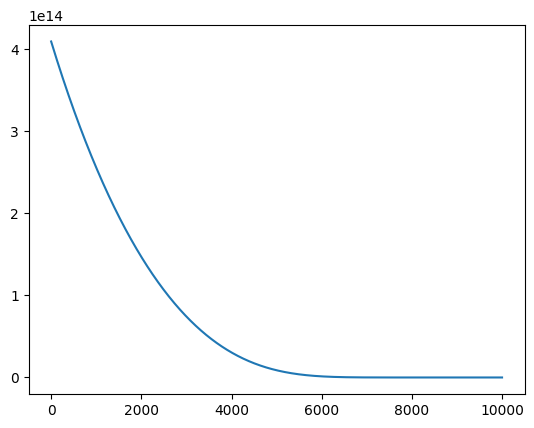

In [570]:
plt.plot(losses)

In [549]:
for name, param in model.named_parameters():
    print(name, param.shape)
    print(param.data)

p_comb_start torch.Size([1, 1])
tensor([[0.5579]])
T_comb_start torch.Size([1, 1])
tensor([[0.5194]])
X_comb_start torch.Size([1, 5])
tensor([[ 0.2762,  0.0657, -0.0365, -0.0077,  0.7463]])
gtu.K torch.Size([])
tensor(10.0586)
gtu.HH_fuel torch.Size([])
tensor(79332496.)
gtu.gas_pTX.raw_model.net.0.weight torch.Size([256, 7])
tensor([[ 0.0538,  0.0198, -0.2921,  ..., -0.3763, -0.3624,  0.3619],
        [ 0.3236,  0.0940,  0.3896,  ..., -0.2168,  0.2971, -0.0077],
        [ 0.0819,  0.2351,  0.2025,  ..., -0.1368, -0.3587,  0.0222],
        ...,
        [-0.0403, -0.0909,  0.1932,  ...,  0.0460, -0.1899, -0.2743],
        [ 0.0690, -0.2942,  0.1116,  ...,  0.2889,  0.0188,  0.0128],
        [-0.2712,  0.2070,  0.0264,  ...,  0.2482,  0.0402,  0.3479]])
gtu.gas_pTX.raw_model.net.0.bias torch.Size([256])
tensor([ 0.2009, -0.2535, -0.3295,  0.3261, -0.2506, -0.0264,  0.1701,  0.1137,
         0.2877, -0.0894, -0.1238,  0.1625,  0.1306,  0.2753,  0.0089,  0.1072,
         0.3620,  0.3574,  

In [78]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

p_comb_start: requires_grad=True
T_comb_start: requires_grad=True
X_comb_start: requires_grad=True
gtu.K: requires_grad=True
gtu.HH_fuel: requires_grad=True
gtu.gas_pTX.raw_model.net.0.weight: requires_grad=False
gtu.gas_pTX.raw_model.net.0.bias: requires_grad=False
gtu.gas_pTX.raw_model.net.2.weight: requires_grad=False
gtu.gas_pTX.raw_model.net.2.bias: requires_grad=False
gtu.gas_pTX.raw_model.net.4.weight: requires_grad=False
gtu.gas_pTX.raw_model.net.4.bias: requires_grad=False
gtu.gas_pTX.raw_model.net.6.weight: requires_grad=False
gtu.gas_pTX.raw_model.net.6.bias: requires_grad=False
gtu.gas_pHX.raw_model.net.0.weight: requires_grad=False
gtu.gas_pHX.raw_model.net.0.bias: requires_grad=False
gtu.gas_pHX.raw_model.net.2.weight: requires_grad=False
gtu.gas_pHX.raw_model.net.2.bias: requires_grad=False
gtu.gas_pHX.raw_model.net.4.weight: requires_grad=False
gtu.gas_pHX.raw_model.net.4.bias: requires_grad=False
gtu.gas_pHX.raw_model.net.6.weight: requires_grad=False
gtu.gas_pHX.raw_m